In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sqlalchemy import create_engine

## Evaluate model on gold standard hold-out set

### Using V1 model

In [2]:
# Load in test data
gold_df = pd.read_csv('../data/phase3/strong_label_cleaned.csv')
gold_df['strong_label'] = gold_df['strong_label'].str.lower()

label2id = {"negative": 0, "neutral": 1, "positive": 2}
gold_df['label'] = gold_df['strong_label'].map(label2id)

train_strong, temp_strong = train_test_split(gold_df,
                                            test_size=0.2,
                                            stratify=gold_df['label'],
                                            random_state=42)

val_strong, test_strong = train_test_split(temp_strong,
                                            test_size=0.5,
                                            stratify=temp_strong['label'],
                                            random_state=42)

# Load Tokenizer + trained model
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
model = AutoModelForSequenceClassification.from_pretrained('../models/v1')
model.eval()  # Set model to evaluation mode

# 3) Tokenize all test examples
encodings = tokenizer(
    test_strong["clean_body"].tolist(),
    truncation=True,
    padding="longest",
    return_tensors="pt"
)

# 4) Do a batched forward pass
with torch.no_grad():
    outputs = model(**encodings)
    logits  = outputs.logits
    preds   = torch.argmax(logits, dim=-1).cpu().numpy()

# 5) Compute and print classification metrics
y_true = test_strong["label"].values
print(classification_report(y_true, preds,
      target_names=["negative","neutral","positive"]))

# 6) Plot confusion matrix
cm = confusion_matrix(y_true, preds)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=["neg","neu","pos"],
            yticklabels=["neg","neu","pos"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Model V1")
plt.show()

### V2 Model

Added LR scheduling, warmup, early stopping, and class weights. Increased number of epochs, and adjusted learning rates.

              precision    recall  f1-score   support

    negative       0.80      0.66      0.72       212
     neutral       0.34      0.46      0.39        69
    positive       0.17      0.25      0.20        24

    accuracy                           0.58       305
   macro avg       0.44      0.46      0.44       305
weighted avg       0.65      0.58      0.61       305



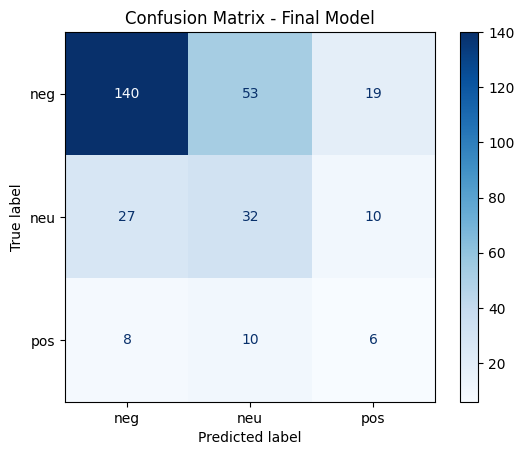

In [3]:
# Load V2 model
tokenizer = AutoTokenizer.from_pretrained('../models/final_model')
model_v2 = AutoModelForSequenceClassification.from_pretrained('../models/final_model')
model_v2.eval()  # Set model to evaluation mode

#Tokenize all test examples
encodings = tokenizer(
    test_strong["clean_body"].tolist(),
    truncation=True,
    padding="longest",
    return_tensors="pt"
)

# Do a batched forward pass
with torch.no_grad():
    outputs = model_v2(**encodings)
    logits  = outputs.logits
    preds   = torch.argmax(logits, dim=-1).cpu().numpy()

# Compute and print classification metrics
y_true = test_strong["label"].values
print(classification_report(y_true, preds,
      target_names=["negative","neutral","positive"]))

# Plot confusion matrix using ConfusionMatrixDisplay
cm = confusion_matrix(y_true, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=["neg","neu","pos"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Final Model")
plt.show()

### Generate sentiment signals on dataset

In [4]:
# Load predictions
df = pd.read_csv('../data/predictions.csv')
df.head()

,Unnamed: 0,id,subreddit,clean_body,date,pred_label,pred_score
0,0,esdguxz,geopolitics,why none?,2019-06-30 00:00:00.000000,1,0.547377
1,1,esdhtud,geopolitics,> who is the realist? it depends on what you m...,2019-06-30 00:00:00.000000,2,0.439600
2,2,esdj0ib,geopolitics,try outline.com,2019-06-30 00:00:00.000000,1,0.475402
3,3,esdj5ht,geopolitics,russia can only be a centralized state due to ...,2019-06-30 00:00:00.000000,1,0.468609
4,4,esdj6vs,geopolitics,migration is not a viable way to offset demogr...,2019-06-30 00:00:00.000000,1,0.398083


In [5]:
df["date"] = pd.to_datetime(df["date"]).dt.date
daily = df.groupby("date").agg(
  comment_count = ("id","count"),
  avg_score     = ("pred_score","mean"),
  pct_positive  = ("pred_label", lambda x:(x==2).mean()),
  pct_negative  = ("pred_label", lambda x:(x==0).mean()),
  pct_neutral   = ("pred_label", lambda x:(x==1).mean()),
).reset_index()


Text(0.5, 0, 'Date')

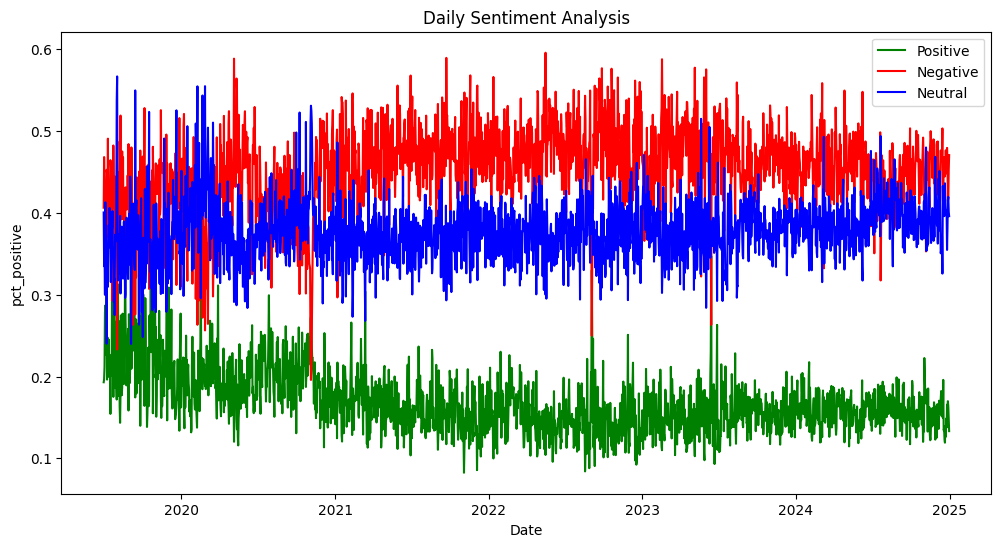

In [7]:
# Plot daily sentiment
plt.figure(figsize=(12, 6))
sns.lineplot(data=daily, x='date', y='pct_positive', label='Positive', color='green')
sns.lineplot(data=daily, x='date', y='pct_negative', label='Negative', color='red')
sns.lineplot(data=daily, x='date', y='pct_neutral', label='Neutral', color='blue')
plt.title('Daily Sentiment Analysis')
plt.xlabel('Date')

### Load Gold Futures Data

In [8]:
# Load gold futures data
engine = create_engine('sqlite:///../reddit_posts.db')
gold = pd.read_sql_table('gold', engine)
gold.head()

,date,Close,High,Low,Open,Volume
0,2019-06-27,1408.400024,1410.800049,1399.800049,1407.000000,437
1,2019-06-28,1409.699951,1422.000000,1408.300049,1408.300049,356
2,2019-07-01,1385.599976,1395.800049,1382.800049,1386.599976,214
3,2019-07-02,1404.599976,1418.400024,1390.800049,1391.099976,38
4,2019-07-03,1417.699951,1434.000000,1413.099976,1431.000000,46


## Statistical Analysis

Trying to establish correlation between sentiment scores and gold futures.

In [9]:
import numpy as np
from scipy.stats import pearsonr, spearmanr
from statsmodels.tsa.stattools import adfuller, ccf, grangercausalitytests
from statsmodels.tsa.vector_ar.var_model import VAR
import statsmodels.api as sm

In [12]:
# Confirm date is datetime in gold and daily
gold['date'] = pd.to_datetime(gold['date'])
daily['date'] = pd.to_datetime(daily['date'])